## Mini Project 03- NLP Emotions: Modelling

Dataset:
- A. Tripathi, "Emotion Classification NLP", Kaggle.com, 2021. [Online]. Available: https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp. [Accessed: 16- Jul- 2022].

Sources:
- WASSA-2017 Shared Task on Emotion Intensity. Saif M. Mohammad and Felipe Bravo-Marquez. In Proceedings of the EMNLP 2017 Workshop on Computational Approaches to Subjectivity, Sentiment, and Social Media (WASSA), September 2017, Copenhagen, Denmark.
BibTex

Emotion Labels:
- joy: 1
- sadness: 2
- anger: 3
- fear: 4

### Import Libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import re as regex
import spacy
from pathlib import Path
import time


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import plot_confusion_matrix
from simple_colors import *

import string
from collections import Counter
import re as regex
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import neattext.functions as nfx
import nltk

import warnings
warnings.filterwarnings('ignore')

import import_ipynb
import nlpEmotion_functions
from nlpEmotion_functions import show_summary_report, svcRocPrecisionRecall, probaRocPrecisionRecall
from nlpEmotion_functions import testRocPrecisionRecall, calcRocAuc

%matplotlib inline

importing Jupyter notebook from nlpEmotion_functions.ipynb


### Load Data

In [2]:
dfData = pd.read_csv("convertedTextDataset.csv")

In [3]:
dfData.head()

,Unnamed: 0,text,label,short
0,0,Just got back from seeing @GaryDelaney in Burs...,1,get see burslem amaze face hurt laugh hilarious
1,1,Oh dear an evening of absolute hilarity I don'...,1,dear even absolute hilarity don think laugh lo...
2,2,Been waiting all week for this game ❤️❤️❤️ #ch...,1,wait week game red heart red heart red heart c...
3,3,"@gardiner_love : Thank you so much, Gloria! Yo...",1,thank gloria sweet thoughtful day joyful love ...
4,4,I feel so blessed to work with the family that...,1,feel bless work family nanny red heart love am...


In [4]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7102 entries, 0 to 7101
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7102 non-null   int64 
 1   text        7102 non-null   object
 2   label       7102 non-null   int64 
 3   short       7097 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.1+ KB


In [5]:
dfData.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [6]:
dfData.shape

(7102, 3)

### Modelling

In [7]:
# Features and Labels
predictors_X= dfData['short']
target_y= dfData['label']
X2= dfData['text']

# split the dataset
X_train, X_test, y_train, y_test= train_test_split(predictors_X, target_y, test_size= 0.2,
                                                   random_state= 42)
X2_train, X2_test, y2_train, y2_test= train_test_split(X2, target_y, test_size= 0.2, random_state= 42)

### Use Bag-of-Words

In [8]:
# create a matrix of word counts from the text
counts= CountVectorizer()

In [9]:
# do the actual counting
A= counts.fit_transform(X_train.values.astype('str'), y_train)

In [10]:
A.shape

(5681, 8917)

In [11]:
# create a classifier using SVC
classifier= SVC(kernel= 'linear', probability= True)

In [12]:
# train the classifier with the training data
%time classifier.fit(A, y_train)

CPU times: total: 12.5 s
Wall time: 12.5 s


SVC(kernel='linear', probability=True)

In [13]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B= counts.transform(X_test.values.astype('str'))

In [14]:
B.shape

(1421, 8917)

In [15]:
# make predictions based on the test data
countPredictions= classifier.predict(B)

In [16]:
countPredictionsProb= classifier.predict_proba(B)
countPredictionsProb[:, 1][:5]

array([0.10559747, 0.07645276, 0.03764908, 0.03242266, 0.0955699 ])

In [17]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, countPredictions))

Accuracy: 0.8198


In [18]:
y_pred_class01= countPredictions
logConfuseMatrix= metrics.confusion_matrix(y_test, y_pred_class01)
print(logConfuseMatrix)

[[277   7  10  29]
 [ 12 229  27  48]
 [ 16  29 264  18]
 [ 11  39  10 395]]


In [19]:
logClassReport= metrics.classification_report(y_test, y_pred_class01)
print(logClassReport)

              precision    recall  f1-score   support

           1       0.88      0.86      0.87       323
           2       0.75      0.72      0.74       316
           3       0.85      0.81      0.83       327
           4       0.81      0.87      0.84       455

    accuracy                           0.82      1421
   macro avg       0.82      0.81      0.82      1421
weighted avg       0.82      0.82      0.82      1421



In [20]:
modelTag= ['countsVect', 'tfidf']
imageTag= []
for i in range(7, 15):
    if (i <= 9):
        img= f'image0{i}'
        imageTag.append(img)
    else:
        img= f'image{i}'
        imageTag.append(img)
imageTag

['image07',
 'image08',
 'image09',
 'image10',
 'image11',
 'image12',
 'image13',
 'image14']

Accuracy  : 0.8198 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8212 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8144 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8173 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9518                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


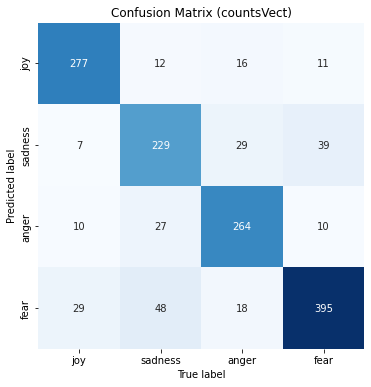

In [21]:
countModelReport= show_summary_report(y_test, countPredictions, countPredictionsProb, modelTag[0],
                                      imageTag[0])

In [22]:
countModelReport[3]

0.8173135940016981

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import time

In [24]:
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

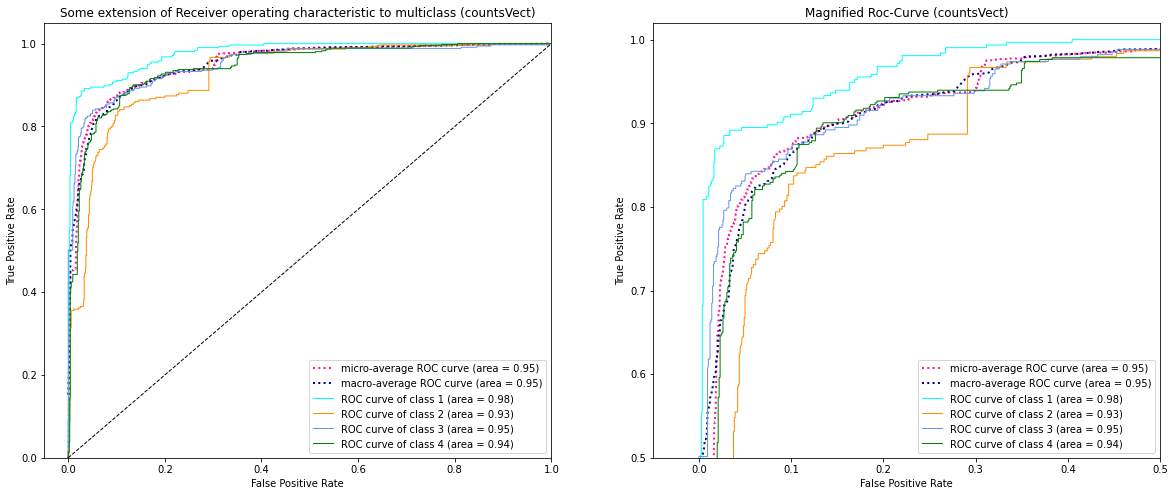

In [25]:
countSvmRocAucData= calcRocAuc(predictors_X, target_y, classifier, counts, modelTag[0], imageTag[1])

In [26]:
%%time
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A3 = tfidf.fit_transform(X2_train.values.astype('U'), y2_train)

# train the classifier with the training data
classifier.fit(A3, y2_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B3 = tfidf.transform(X2_test.values.astype('U'))

CPU times: total: 30.1 s
Wall time: 30.2 s


In [27]:
# make predictions based on the test data
tfidfPredictions2 = classifier.predict(B3)

tfidfPredictionsProb2 = classifier.predict_proba(B3)

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y2_test, tfidfPredictions2))

Accuracy: 0.8733


### Using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [28]:
%%time
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A2 = tfidf.fit_transform(X_train.values.astype('U'), y_train)

# train the classifier with the training data
classifier.fit(A2, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B2 = tfidf.transform(X_test.values.astype('U'))

# make predictions based on the test data
tfidfPredictions = classifier.predict(B)

tfidfPredictionsProb = classifier.predict_proba(B)

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, tfidfPredictions))

Accuracy: 0.8431
CPU times: total: 15.5 s
Wall time: 15.5 s


In [29]:
A2.shape

(5681, 8917)

In [30]:
B2.shape

(1421, 8917)

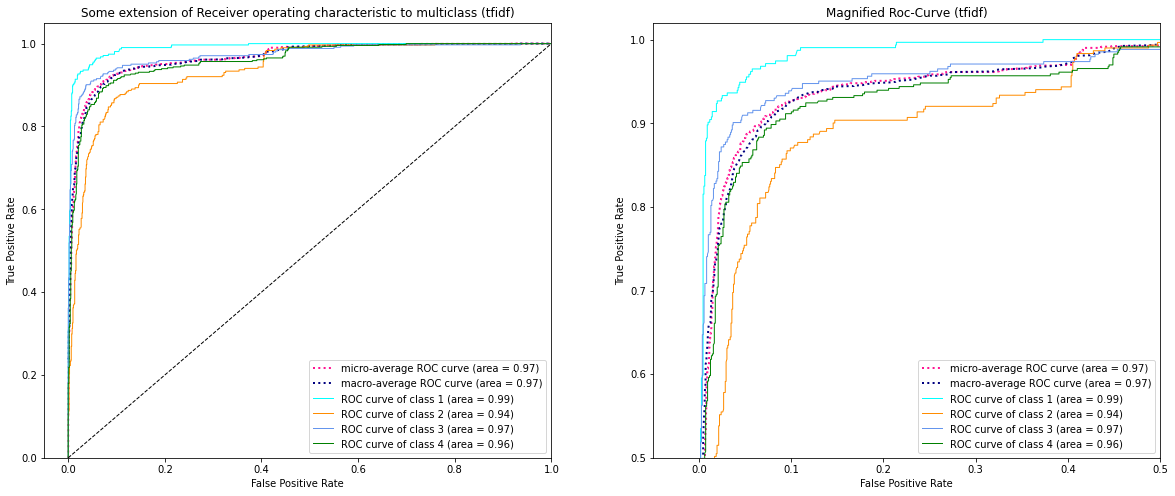

In [31]:
tfidfSvmRocAucData= calcRocAuc(predictors_X, target_y, classifier, tfidf, modelTag[1], imageTag[2])

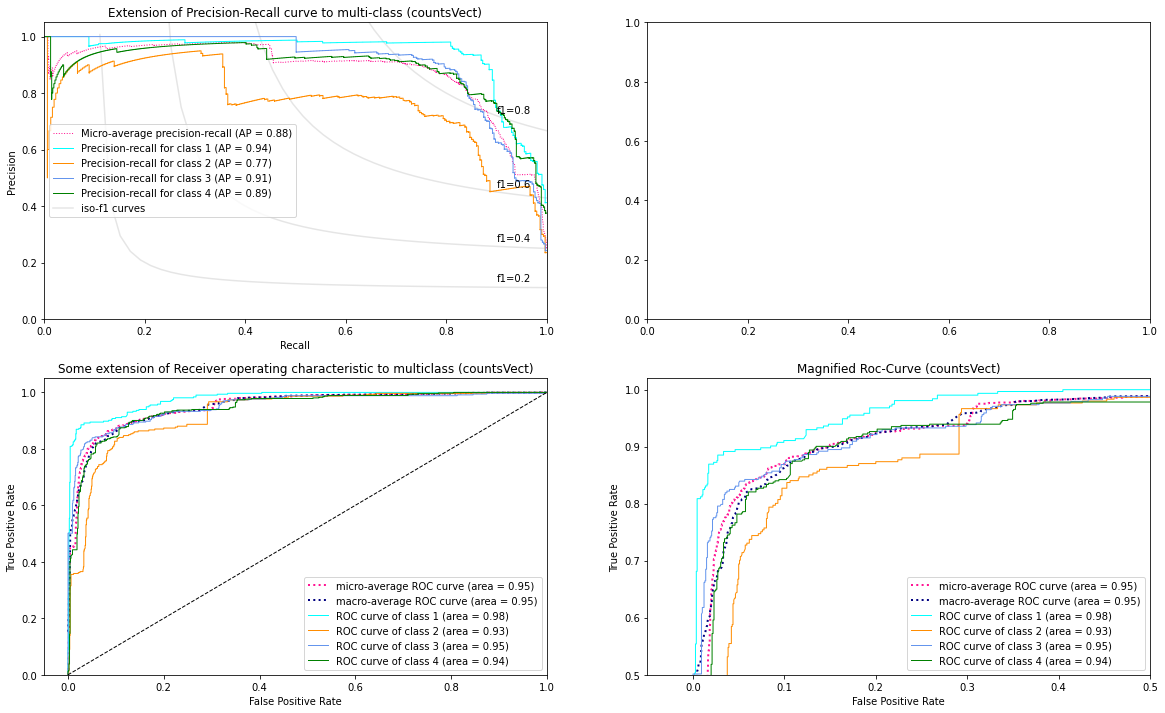

In [33]:
countSvmPrecisionRecallData= testRocPrecisionRecall(predictors_X, target_y, classifier, counts,
                                                        modelTag[0], imageTag[3])

Accuracy  : 0.8198 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8212 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8144 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8173 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9518                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


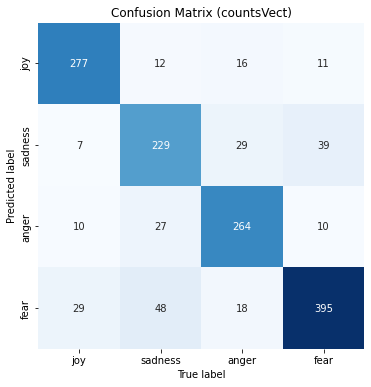

In [34]:
countModelReport01= show_summary_report(y_test, countPredictions, countPredictionsProb, modelTag[0],
                                        imageTag[4])

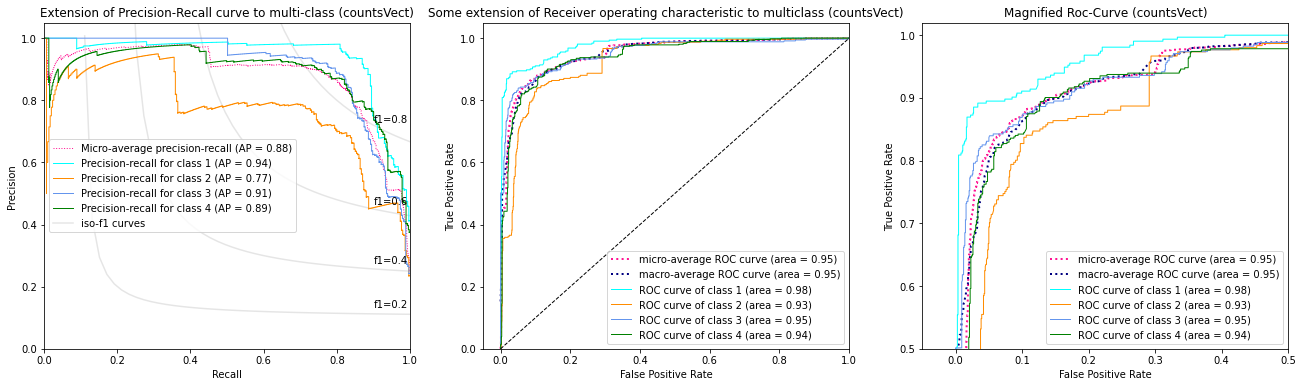

In [35]:
countSvmPrecisionRecallData02= svcRocPrecisionRecall(predictors_X, target_y, classifier, counts,
                                                      modelTag[0], imageTag[5])

Accuracy  : 0.8431 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision : 0.8411 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall    : 0.8445 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
f1-score  : 0.8426 [2 * (Precision * Recall)/ (Precision + Recall)]                    Best: 1, Worst: 0
ROC AUC   : 0.9569                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


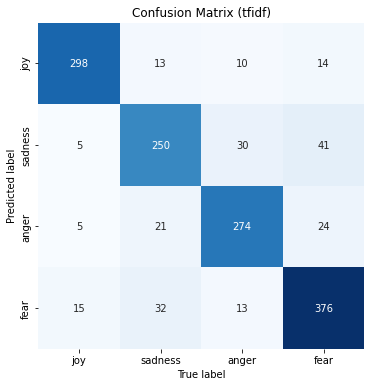

In [36]:
tfidfModelReport02= show_summary_report(y_test, tfidfPredictions, tfidfPredictionsProb,
                                        modelTag[1], imageTag[6])

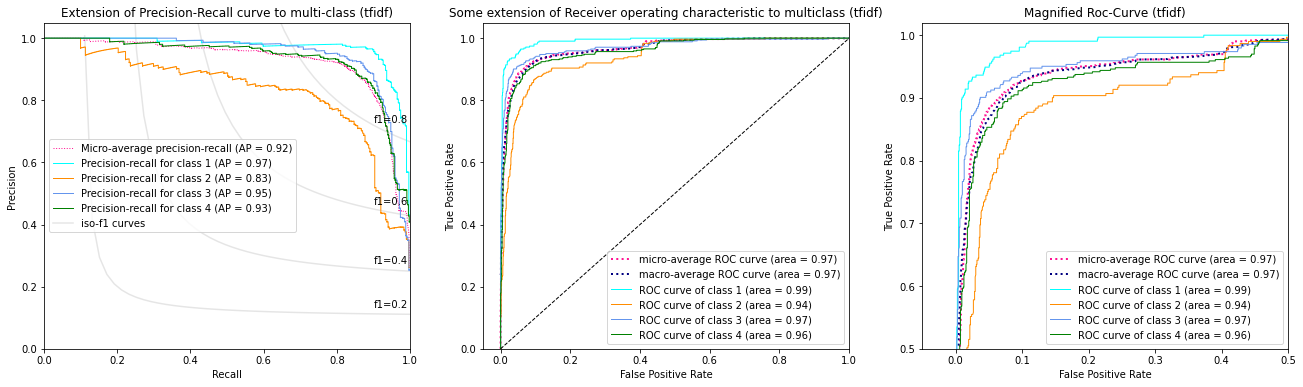

In [37]:
tfidfSvmPrecisionRecallData02= svcRocPrecisionRecall(predictors_X, target_y, classifier, tfidf,
                                                      modelTag[1], imageTag[7])

In [38]:
countSvmPrecisionRecallData02[12]

0.8815104954791113